In [17]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [49]:
import math 
import torch 
import random

In [86]:

"""
suppose you have this expression : 
x = b + d 
f = a * x + c 

the tree is gonna look something like this : 


 +-------------------+f +--------------------+  
 |                   ++-+                    |  
 |                    |                      |  
 |                    |                      |  
 v                    v                      v  
+--+      +--+      +---+       +----+     +---+
| a|      |* |  +---+ x +---+   |  + |     | c |
+--+      +--+  |   +-+-+   |   +----+     +---+
                |     |     |                   
                |     |     |                   
                |     |     |                   
                v     v     v                   
              +--+   +--+  +--+                 
              |b |   |+ |  | d|                 
              +--+   +--+  +--+                 



f._children = {a, x, c}

**grad: 
s --> c ---> f 

ds/df = ds/dc * dc/df 



"""
class Value:
    def __init__(self, value):
        self.data = value
        self.grad = 0.0
        self._children = set()
        self._op = ""
        self.label = ""
        self._backward = lambda : None
            
    def __repr__(self):
        out = f"Value(data={self.data}, grad={self.grad}, children={self._children})"
        return out 

    def __add__(self, other):
        res = self.data + other.data
        out = Value(res)
        out._children.update([self, other])  
        out._op = "+"    
        out.label = "$"
        def compute_grad(): 
            for child in out._children:
                child.grad += out.grad
            # self.grad += out.grad
            # other.grad += out.grad
        
        out._backward = compute_grad 
        return out
    
    def __mul__(self, other): 
        res = self.data * other.data
        out = Value(res)
        out._op = "*"
        out._children.update([self, other])
        out.label = "$"    
        def compute_grad(): 
            total_power = 1.0
            for child in out._children:
                total_power *= child.data
            for child in out._children: 
                child.grad += out.grad * (total_power / child.data) 
            # self.grad += out.grad * other.data
            # other.grad += out.grad * self.data

        out._backward = compute_grad
        return out 
    
    def tanh(self): 
        self.data = math.tanh(self.data)
        return self

In [19]:
def backprop(root : Value): 
    root._backward()
    for child in root._children: 
        backprop(child)




In [27]:
a = Value(2.0); a.label = "a"
b = Value(1.0); b.label = "b"
c = a * b ; c.label = "c"
d = Value(6.0) ; d.label = "d"
e = d * c ; e.label = "e" 

f = Value(-1.0) ; f.label = "f" 
g = f * e ; g.label = "g"


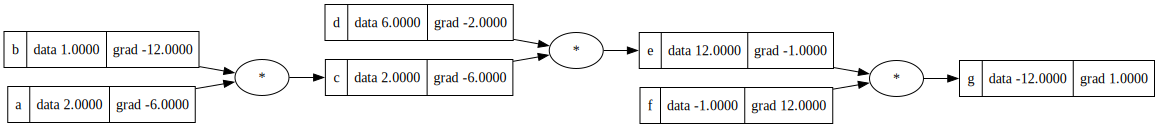

In [28]:
g.grad = 1.0 
backprop(g)
draw_dot(g)

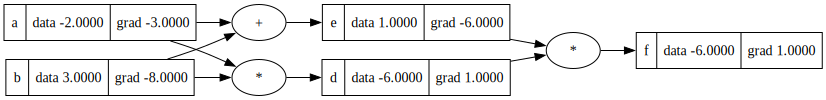

In [37]:
a = Value(-2.0); a.label='a'
b = Value(3.0); b.label='b'
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.grad = 1.0
backprop(f)

draw_dot(f)

In [ ]:
class Neuron:
    """
    provide the number of weights for the neuron 
    """
    
    def __init__(self, input_size : int):
        self.bias = Value(random.uniform(-1, 1)) 
        self.weights = [Value(random.uniform(-1, 1)) for x in range(input_size)]
        self.bias.label = "bias"
        for i in range(input_size): 
            self.weights[i].label = f"w{i}"

    def __call__(self, input : list[Value]):
        for i in range(len(input)):
            input[i].label = f"x{i}" 
        tmp = sum((self.weights[i] * input[i] for i in range(len(input))), self.bias)
        out = tmp.tanh() 
        return out 
    
    def __repr__(self):
        return f"Neuron({self.weights})"


class Layer:
    """
    provide the number of neurons and number of inputs of each neuron 
    """
    def __init__(self, neuron_nbr: int, input_size: int):
         self.neurons = [Neuron(input_size=input_size) for _ in range(neuron_nbr)]
    
    def __repr__(self):
        return f"Layer({self.neurons})"

    def __call__(self, input:list[Value]):
        out = []
        for neuron in self.neurons : 
            out.append(neuron(input))
        return out

    def get_params(self): 
        out = []
        for neuron in self.neurons : 
            out.extend(neuron.weights)
        return out 
    


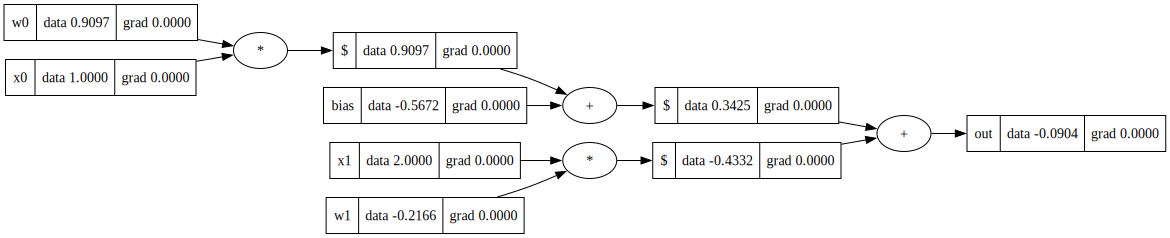

In [87]:
N = Neuron(2)
x = [Value(1.0), Value(2.0)]
out = N(x) ; out.label = "out"
out 
draw_dot(out)

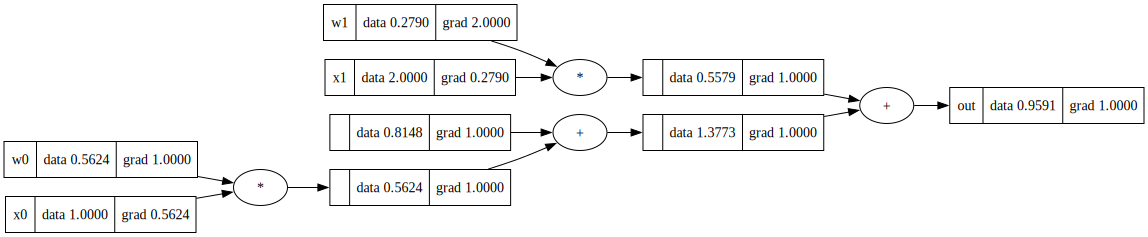

In [67]:
out.grad = 1.0
backprop(out)
draw_dot(out)

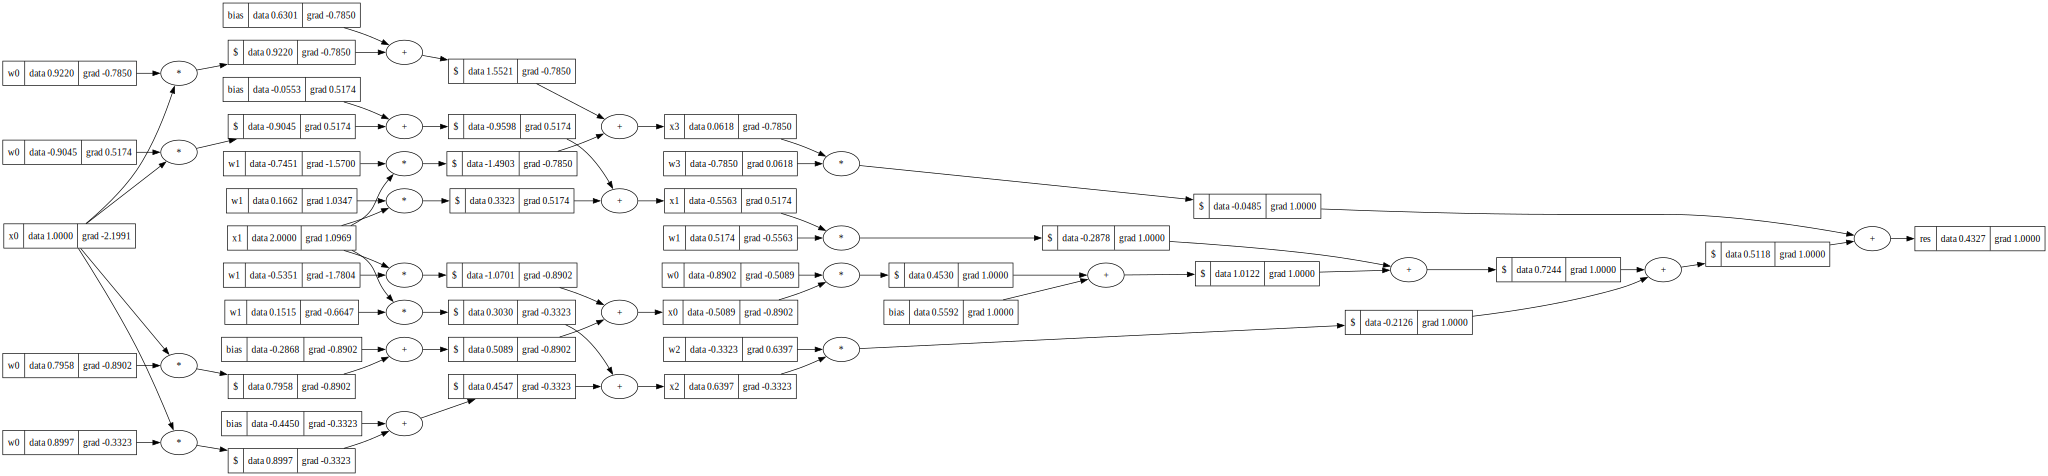

In [97]:
L1 = Layer(4, 4)
L2 = Layer(1, 4)

res = L2(L1(x))
res = res[0]
res
res.grad = 1.0 
res.label = "res"
backprop(res)
draw_dot(res)